# 準備

In [1]:
# -*- coding: utf-8 -*-
import os
import datetime as dt
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm
from pymongo import MongoClient
import burst_detection as bd

from s_lib import setup_mongo, setup_mecab

## date_range(start, end)<br>連続した日付データ作成
閉区間[start, end]の範囲で出力する

In [2]:
def date_range(start, end):
    for n in range((end - start).days + 1):
        yield start + timedelta(n)

## plot_migoro(x, q, pref, flag)<br>見頃推定をplotする

In [3]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib.dates import date2num

def plot_migoro(x, q, pref, flag):
    
    y_correct = []
    if flag == "sonota" or flag == "koyo":
        for date in x:
            if ( CORRECTS[pref]["kaede"]['start'] <= date <= CORRECTS[pref]["kaede"]['end']
                or CORRECTS[pref]["icho"]['start'] <= date <= CORRECTS[pref]["icho"]['end']):
                y_correct.append(1)
            else:
                y_correct.append(0)
    elif flag == "sakura":
        for date in x:
            if dt.date(2015, 4, 25) <= date <= dt.date(2015, 5, 5):
                y_correct.append(1)
            else:
                y_correct.append(0)
    else: 
        for date in x:
            if  CORRECTS[pref][flag]['start'] <= date <= CORRECTS[pref][flag]['end']:
                y_correct.append(1)
            else: 
                 y_correct.append(0)
                    
    figure_ = plt.figure()  # Figure作成
    figure_.text(0.2, 0.5, str(pref) + ": " + str(flag), fontsize=20)
    figure_.text(0.2, 0.4, "simozono", fontsize=20)
    
    axes_ = figure_.add_subplot(111)  # Axes作成
    xaxis_ = axes_.xaxis  # XAxis取得
    
    x_numdate = date2num([
        dt.date(2015, 8, 15), 
        dt.date(2015, 9, 1), dt.date(2015, 9, 15), 
        dt.date(2015, 10, 1), dt.date(2015, 10, 15), 
        dt.date(2015, 11, 1), dt.date(2015, 11, 15), 
        dt.date(2015, 12, 1), dt.date(2015, 12, 15), dt.date(2015, 12, 31)
    ])
    
    axes_.xaxis.set_major_locator(ticker.FixedLocator(x_numdate))
    axes_.tick_params(axis='x', rotation=270)
    xaxis_.set_major_formatter(DateFormatter('%m-%d'))
    
    axes_.plot(x, y_correct, label='correct')
    axes_.plot(x, q, label='burst')
    plt.legend()
    
    fname = f"{pref}_{flag}.png"
    out_dir = f"/Users/daigo/workspace/koyo/_simozono/result/"
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(out_dir + fname)
    plt.show()
    
    plt.close()

## evaluate(result, pref, flag, dates)<br>F値を算出する

In [4]:
def evaluate(result, pref, flag, dates):       
    # dates: 評価する期間
    """
    tp: true positives
    tn: true negatives
    fn: false negativess
    fp: false positives
    """
    tp, tn, fn, fp = 0, 0, 0, 0
    if flag in ["icho", "kaede"]:
        correct_period = [date for date in date_range(CORRECTS[pref][flag]['start'], \
                                                      CORRECTS[pref][flag]['end'])]
    elif flag == "sakura":
        correct_period = [date for date in date_range(dt.date(2015, 4, 25), \
                                                      dt.date(2015, 5, 5))]
    else: 
        icho_period = [date for date in date_range(CORRECTS[pref]['icho']['start'], \
                                                      CORRECTS[pref]['icho']['end'])]
        kaede_period = [date for date in date_range(CORRECTS[pref]['kaede']['start'], \
                                                      CORRECTS[pref]['kaede']['end'])]
        
        correct_period = icho_period + kaede_period
        correct_period = list(set(correct_period))
          
    for oneday in dates:
        if oneday in correct_period:
            # oneday = oneday.isoformat()
            if result.at[oneday, "burst"] == 1:
                tp += 1
            elif result.at[oneday, "burst"] == 0:
                tn += 1
            else:
                print("error")
        else:
            if result.at[oneday, "burst"] == 1:
                fp += 1
            elif result.at[oneday, "burst"] == 0:
                fn += 1
            else:
                print("error")
    
    if tp == 0:
        recall = precision = fscore = 0
    else:
        recall = tp / len(correct_period)
        precision = tp / (tp + fp)
        fscore = (2 * recall * precision) / (recall + precision)
    
    # 評価値を出す
#     print(f"[{pref}]: {flag}")
#     print(f"recall: {recall}")
#     print(f"precision: {precision}")
    print(f"{flag}: {fscore}")
    
    return recall, precision, fscore

結果1日単位で書き込む<br>save_burst_date(dates, q, pref, flag, rate)

In [19]:
def save_burst_date(dates, q, pref, flag):
    dir_path = "/Users/daigo/workspace/koyo/_simozono/result/" + "busrt_dates/"
    f_name = f"{pref}_{flag}.csv"
    
    os.makedirs(dir_path, exist_ok=True)
    
    with open(dir_path + f_name, mode='w') as f:
        for i, date in enumerate(dates):
            f.write(f"{date}, {q[i]}\n")

# main

# 桜

### データ読み込み

In [6]:
dates = [
    pd.to_datetime(date).date() 
    for date in pd.date_range(start="2015-02-17", end="2015-12-31", tz="Japan", freq="D")
]
dates = pd.DataFrame(dates, columns=["date"])

In [7]:
tweet_count = pd.read_csv('hk_all_cleaning.txt', usecols=[2], sep='\t', header=None, names=["count"])
sakura_count = pd.read_csv('hk_sakura_cleaning.txt', usecols=[2], sep='\t', header=None, names=["count"])
tweet_count = tweet_count.set_index(dates["date"])
sakura_count = sakura_count.set_index(dates["date"])

### 見頃推定

In [8]:
r = sakura_count["count"]
d = tweet_count["count"]
n = len(dates)

q, d, r, p = bd.burst_detection(r,d,n,s=1.5,gamma=1,smooth_win=1)
bursts = bd.enumerate_bursts(q, 'burstLabel')

#find weight of bursts
weighted_bursts = bd.burst_weights(bursts,r,d,p)

In [9]:
result = pd.DataFrame(q, columns=["burst"], index=dates["date"])

In [10]:
print('観測確率 observed probabilities: ')
#print(str(r/d) )

print( '最適状態列 optimal state sequence: ')
print(str(q.T) )

print('ベースライン確率 baseline probability: ' + str(p[0]) )

print('バースト確率 bursty probability: ' + str(p[1]) )

print('weighted bursts:')
print(weighted_bursts)

観測確率 observed probabilities: 
最適状態列 optimal state sequence: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [11]:
# plot_migoro(dates["date"], result["burst"], "hk", "sakura")
recall, precision, fscore = evaluate(result, "hk", "sakura", dates["date"])

sakura: 0.6111111111111112


# 紅葉

### データ読み込み

In [12]:
prefs = ['tk', 'hk', 'is']
flags = ["icho", "kaede", "sonota", "koyo"] 

icho = ["いちょう", "イチョウ", "銀杏"]
kaede = ["かえで", "カエデ", "楓"]
sonota = ["こうよう", "もみじ", "紅葉", "黄葉", "コウヨウ", "モミジ"]
koyo = icho + kaede + sonota

keywords = {
    "icho": icho,
    "kaede": kaede,
    "sonota": sonota,
    "koyo": koyo
}

CORRECTS = {
    "tk": {
        "kaede": {"start": dt.date(2015, 12, 4), "end": dt.date(2015, 12, 12)},
        "icho": {"start": dt.date(2015, 11, 30), "end": dt.date(2015, 12, 11)},
    },
    "hk": {
        "kaede": {"start": dt.date(2015, 10, 29), "end": dt.date(2015, 11, 29)},
        "icho": {"start": dt.date(2015, 11, 2), "end": dt.date(2015, 11, 12)},
    },
    "is": {
        "kaede": {"start": dt.date(2015, 11, 22), "end": dt.date(2015, 12, 3)},
        "icho": {"start": dt.date(2015, 11, 4), "end": dt.date(2015, 11, 10)}
    }
}

START_DATE = dt.date(2015, 8, 15) # plotする期間
END_DATE = dt.date(2015, 12,31)

dates_list = [
    pd.to_datetime(date).date() 
    for date in pd.date_range(start="2015-08-15", end="2015-12-31", tz="Japan", freq="D")
]
dates = pd.DataFrame(dates_list, columns=["date"])

In [13]:
flag_count_dir = "/Users/daigo/workspace/koyo/_simozono/simple_count_0815to1231/"
all_count_dir = "/Users/daigo/workspace/koyo/result/00total_count/"

count = {}

for pref in prefs:
    count[pref] = pd.DataFrame(dates_list, columns=["date"])
    for flag in flags:
        tmp = pd.read_csv(f"{flag_count_dir}{pref}_{flag}_count.txt", header=None, names=["date", "count"], sep='\t')
        count[pref][flag] = tmp["count"]

for pref in prefs:
    for flag in flags:
        tmp = pd.read_csv(f"{all_count_dir}{pref}_total_dailycount.txt", header=None, names=["date", "count"], sep='\t')
        count[pref]["all"] = tmp["count"]

display(count["tk"])

,date,icho,kaede,sonota,koyo,all
0,2015-08-15,1,2,3,6,43487
1,2015-08-16,1,3,1,5,43343
2,2015-08-17,0,2,1,3,46147
3,2015-08-18,1,4,4,9,48661
4,2015-08-19,1,3,4,8,56363
...,...,...,...,...,...,...
134,2015-12-27,6,3,6,14,14091
135,2015-12-28,2,3,6,10,14039
136,2015-12-29,3,1,1,5,14747
137,2015-12-30,7,5,1,13,19473


### 見頃推定

In [14]:
scores = pd.DataFrame(0.0, columns=prefs, index=flags)

tk
icho: 0.4799999999999999


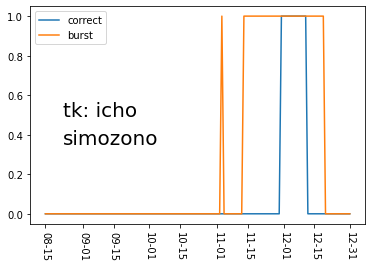

kaede: 0


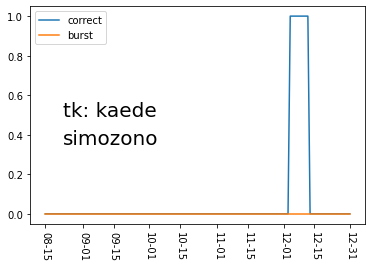

sonota: 0.46428571428571425


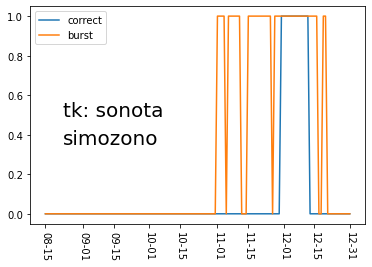

koyo: 0.43333333333333335


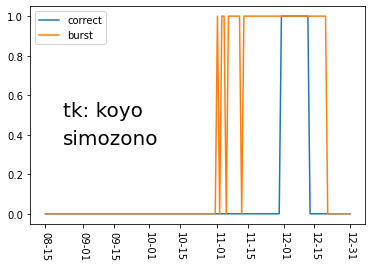

hk
icho: 0.2608695652173913


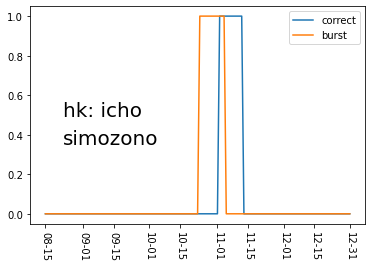

kaede: 0


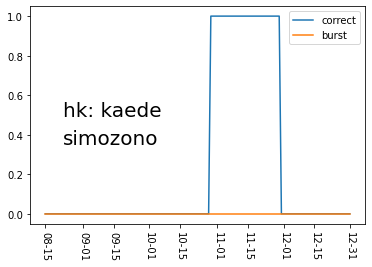

sonota: 0.45614035087719296


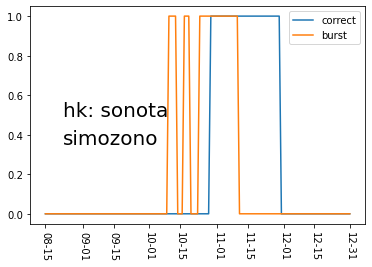

koyo: 0.45614035087719296


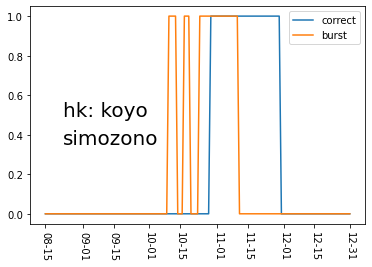

is
icho: 0


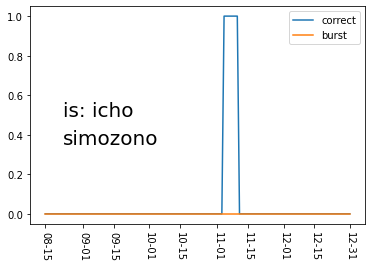

kaede: 0


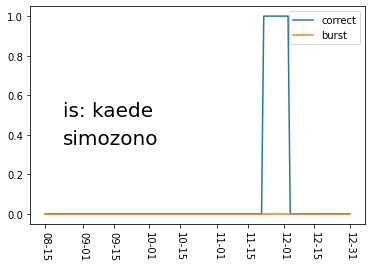

sonota: 0.6060606060606061


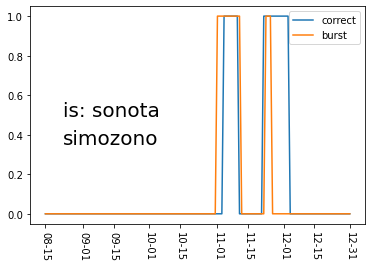

koyo: 0.6060606060606061


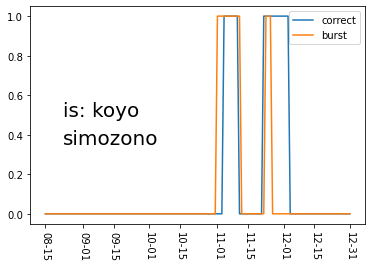

In [15]:
for pref in prefs:
    print(pref)
    for flag in flags:
        r = count[pref][flag]
        d = count[pref]["all"]
        n = len(dates_list)
        
        q, d, r, p = bd.burst_detection(r,d,n,s=2.0,gamma=1,smooth_win=1)
        bursts = bd.enumerate_bursts(q, 'burstLabel')
        #find weight of bursts
        weighted_bursts = bd.burst_weights(bursts,r,d,p)
        
        result = pd.DataFrame(q, columns=["burst"], index=dates_list)
        
        recall, precision, fscore = evaluate(result, pref, flag, dates_list)
        scores.at[flag, pref] = fscore
        
        plot_migoro(dates_list, result["burst"], pref, flag)
        save_burst_date(dates_list, result["burst"], pref, flag)

In [16]:
scores.to_csv(f"/Users/daigo/workspace/koyo/_simozono/result/scores_2.0.tsv", sep='\t')
scores

,tk,hk,is
icho,0.480000,0.26087,0.000000
kaede,0.000000,0.00000,0.000000
sonota,0.464286,0.45614,0.606061
koyo,0.433333,0.45614,0.606061


In [17]:
class HorizontalDisplay:
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(arg._repr_html_())
                         for arg in self.args)

In [18]:
import itertools

FIXED_NUMS = [50, 150, 250, 500]
rtweets_count_dir = "/Users/daigo/workspace/koyo/result/" + "rtweets_count/"
total_count_dir = "/Users/daigo/workspace/koyo/result/" + "total_count/"

target_counts = dict()
total_counts = dict()

for pref in prefs:
    target_counts[pref] = {}
    for flag in flags:
        target_counts[pref].update({flag: [[], [], [], []]})
        
target_counts['tk']

for pref, flag in  itertools.product(prefs, flags):
    for i, fixed_num in enumerate(FIXED_NUMS):
        filename = f"{pref}_{flag}_{str(fixed_num).zfill(3)}rwords_count.txt"
        with open(rtweets_count_dir+filename, "r") as target_file:
             target_counts[pref][flag][i] = [line.rstrip('\n').split('\t')[1] for line in target_file.readlines()]
                
for pref in prefs:
    filename = pref + "_total_dailycount.txt"
    with open(total_count_dir+filename, "r") as total_file:
        total_counts[pref] = [line.rstrip('\n').split('\t')[1] for line in total_file.readlines()]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/daigo/workspace/koyo/result/rtweets_count/tk_icho_050rwords_count.txt'

In [ ]:
pd.set_option('display.max_rows', 500)
print(target_counts["is"]["koyo"][0])
# HorizontalDisplay(count["is"], target_counts["is"]["koyo"][2])

In [ ]:
# display(count["is"])